In [3]:
import ElecResponse, responses, numpy as np, matplotlib.pyplot as plt, torch, h5py as h5

In [4]:
#Load field response from garfield file
field_response = responses.load('dune-garfield-1d565.json.bz2')

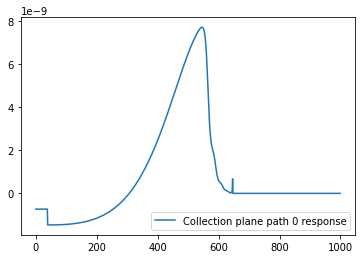

In [12]:
#Plot current in a collection wire from one electron path 
plt.plot(field_response.planes[2].paths[0].current, label='Collection plane path 0 response'); plt.legend()

In [16]:
len(field_response.planes[2].paths[0].current)

1000

In [17]:
field_response.period

99.998998998999

In [15]:
#Make an electronics response instance, defined by gain and shaping time
elec_response_for_field = ElecResponse.ElecResponse(14., 2.)

In [40]:
#Make an electronics response in the same coarseness of the field response
#Units of period is ns, units of shaping time is us
the_response = elec_response_for_field.forward(torch.Tensor(np.linspace(0, 1e-3*field_response.period*len(field_response.planes[2].paths[0].current), len(field_response.planes[2].paths[0].current))))

In [27]:
scale_factor = ((1 << 12) - 1) / 1.4e3 #ADC / mV 

In [28]:
scale_factor

2.925

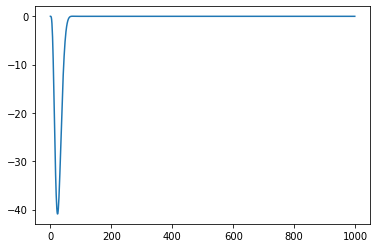

In [43]:
plt.plot((the_response * -1* scale_factor))

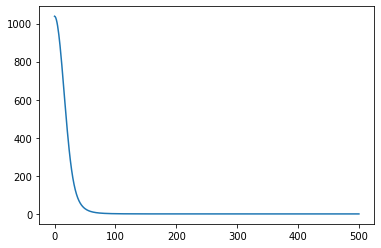

In [46]:
fftd_elec_response = torch.fft.rfft(the_response * -1* scale_factor)
plt.plot(torch.sqrt(fftd_elec_response.real**2 + fftd_elec_response.imag**2))

In [47]:
avg_response = responses.wire_region_average(field_response)

In [48]:
avg_response_tensor = avg_response.as_tensor()

In [49]:
plane2_avg_response = avg_response_tensor[2]

In [51]:
plane2_avg_response.shape

torch.Size([21, 1000])

In [52]:
fftd_elec_response.shape

torch.Size([501])

In [98]:
fftd_plane2_avg_response = torch.fft.rfft(plane2_avg_response, axis=1)

In [100]:
fftd_plane2_avg_response.shape

torch.Size([21, 501])

In [144]:
field_and_elec = torch.fft.irfft(fftd_plane2_avg_response * fftd_elec_response*avg_response.period*1.e-3)

In [145]:
field_and_elec.shape

torch.Size([21, 1000])

In [146]:
modded = torch.zeros_like(field_and_elec)
good_vals = field_and_elec[torch.where(torch.abs(field_and_elec) > 1e-5)]
modded[torch.where(torch.abs(field_and_elec) > 1e-5)] = torch.sign(good_vals)*torch.log10(1e5*torch.abs(good_vals))

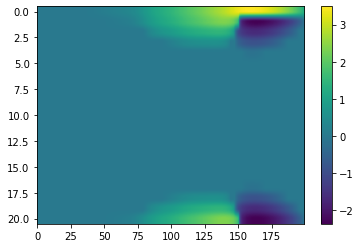

In [147]:
plt.imshow(modded[:,500:700], aspect='auto'); plt.colorbar()

In [75]:
modded.shape

torch.Size([21, 1000])

In [81]:
field_response.planes[2].paths[0].pitchpos

-49.455

In [85]:
avg_response.planes[2].paths

21

In [105]:
plane2_response = field_response.as_tensor()[2]
fftd_plane2_response = torch.fft.rfft(plane2_response, axis=1)

In [141]:
field_and_elec_full = torch.fft.irfft(fftd_plane2_response * fftd_elec_response*1.e-3*field_response.period)

In [142]:
modded = torch.zeros_like(field_and_elec_full)
good_vals = field_and_elec_full[torch.where(torch.abs(field_and_elec_full) > 1e-5)]
modded[torch.where(torch.abs(field_and_elec_full) > 1e-5)] = torch.sign(good_vals)*torch.log10(1e5*torch.abs(good_vals))

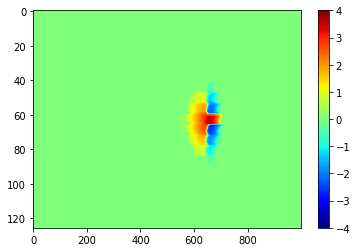

In [143]:
plt.imshow(modded, aspect='auto', vmin=-4, vmax=4, cmap='jet'); plt.colorbar()

In [95]:
field_response.planes[2].paths[0].pitchpos

-49.455

In [110]:
f = h5.File('pdsp_wires.h5')

In [116]:
wires = torch.Tensor(f['wires'][0])

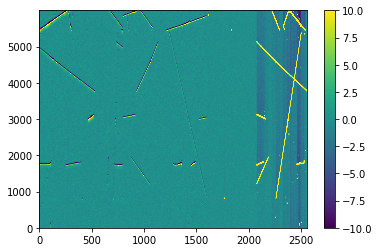

In [123]:
plt.imshow((wires.T - torch.mean(wires, axis=1)), aspect='auto', vmin=-10, vmax=10, origin='lower'); plt.colorbar()

In [201]:
coll = torch.Tensor(wires[-480:].T - torch.mean(wires[-480:], axis=1)).T

In [203]:
coll.shape

torch.Size([480, 6000])

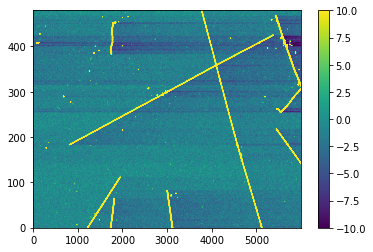

In [202]:
plt.imshow(coll, aspect='auto', vmin=-10, vmax=10, origin='lower'); plt.colorbar()

In [149]:
redigit = responses.redigitize(field_and_elec, 100*1e-3, .5, 6000)

In [151]:
redigit_fftd = torch.fft.fft(torch.fft.rfft(redigit,axis=1), axis=0)

In [205]:
coll_fftd = torch.fft.fft(torch.fft.rfft(coll,axis=1), axis=0)

In [204]:
redigit.shape

torch.Size([21, 6000])

In [323]:
padded = torch.zeros((480, 6000))

In [324]:
padded[:21] = redigit

In [325]:
padded_fft = torch.fft.fft(torch.fft.rfft(padded, axis=1), axis=0)

In [328]:
responsed_coll = torch.fft.irfft(torch.fft.ifft(filter((coll_fftd/padded_fft).T).T, axis=0), axis=1)

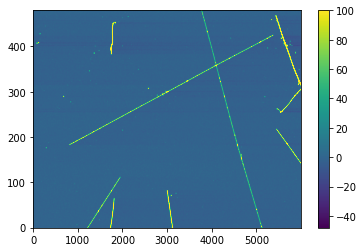

In [329]:
plt.imshow(coll, aspect='auto', vmax=100, origin='lower'); plt.colorbar()

joined = (wires[-960:].T - torch.mean(wires[-960:], axis=1)).T

In [ ]:
plt.imshow()

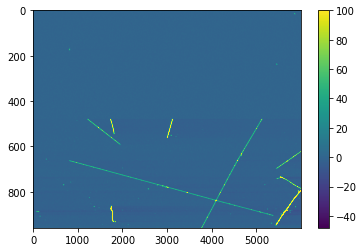

In [369]:
plt.imshow(joined, aspect='auto', vmax=100); plt.colorbar()

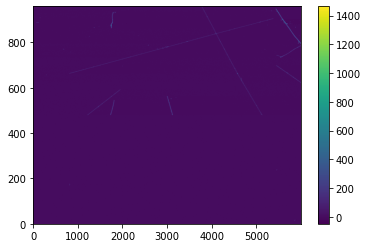

In [370]:
plt.imshow(joined, aspect='auto', origin='lower'); plt.colorbar()

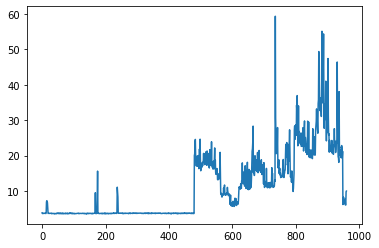

In [308]:
plt.plot(torch.std(wires[-960:],axis=1))

In [367]:
padded = torch.zeros((960, 6000))
padded[:21] = redigit
padded_fft = torch.fft.fft(torch.fft.rfft(padded, axis=1), axis=0)

In [361]:
joined_fft = torch.fft.fft(torch.fft.rfft(joined, axis=1), axis=0)

In [364]:
responsed_joined = torch.fft.irfft(torch.fft.ifft(filter((joined_fft/padded_fft).T).T, axis=0), axis=1)

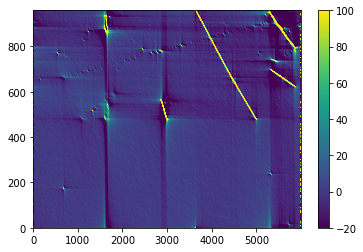

In [365]:
plt.imshow(responsed_joined, aspect='auto', origin='lower', vmin=-20, vmax=100); plt.colorbar()

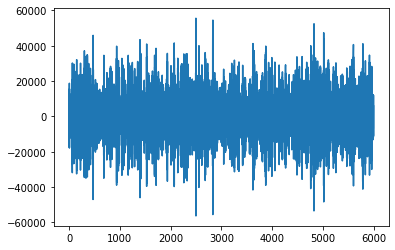

In [244]:
plt.plot(responsed_joined[500])

In [398]:
joined2 = torch.zeros(1920, 6000)

In [400]:
joined2[:480] = wires[-960:-480]
joined2[960:1440] = wires[-480:]
joined2[480:960] = torch.mean(wires[-960:])
joined2[1440:] = torch.mean(wires[-960:])

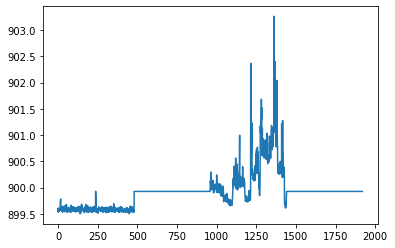

In [401]:
plt.plot(torch.mean(joined2, axis=1))

In [350]:
torch.mean(joined2, axis=1).shape

torch.Size([981])

In [275]:
joined2.shape

torch.Size([981, 6000])

In [402]:
joined2 = (joined2.T - torch.mean(joined2, axis=1)).T

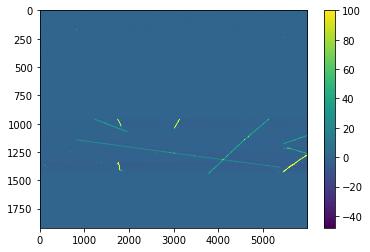

In [403]:
plt.imshow(joined2, aspect='auto', vmax=100); plt.colorbar()

In [404]:
joined2_fft = torch.fft.fft(torch.fft.rfft(joined2, axis=1), axis=0)

In [397]:
padded2 = torch.zeros((1920, 6000))
padded2[:21] = redigit
padded2_fft = torch.fft.fft(torch.fft.rfft(padded2, axis=1), axis=0)

In [405]:
responsed_joined2 = torch.fft.irfft(torch.fft.ifft(filter((joined2_fft/padded2_fft).T).T, axis=0), axis=1)

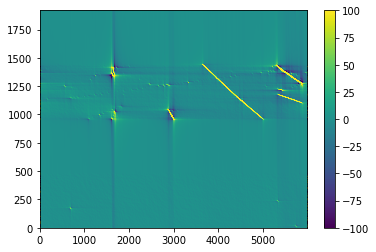

In [406]:
plt.imshow(responsed_joined2, aspect='auto', vmax=100, vmin=-100, origin='lower');plt.colorbar()

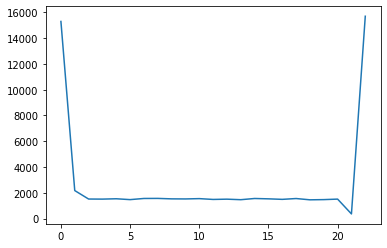

In [307]:
plt.plot(torch.std(responsed_joined2[479:502], axis=1))

In [309]:
import HfFilter

In [310]:
filter = HfFilter.HfFilter()

In [317]:
filtered2 = torch.fft.irfft(torch.fft.ifft(filter((joined2_fft/padded2_fft).T).T, axis=0), axis=1)

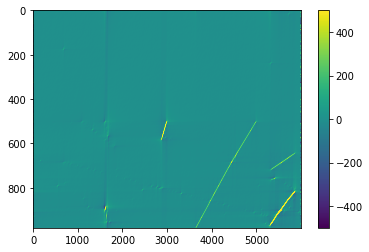

In [319]:
plt.imshow(filtered2, aspect='auto', vmax=500, vmin=-500); plt.colorbar()